# AML Peds PaCMAP Classifier Benchmark

```{contents}
```

Here we benchmark the performance of the classifiers using `Supplemental 1` of previous notebook: "The Methylome Atlas of Pediatric AML".

We verify whether selecting only pediatric AML samples in PaCMAP offers better predictive power.

Conclusion: Limiting our dataset to pediatric AML trials significantly reduces sample size. This results in a significant drop in performance for rare subtypes like APL (n=1), Mecom (n=5), and MDS-related (n=15). However, the performance of the classifier for the remaining subtypes is comparable to the performance of the classifier trained on the full dataset. 

## Load data

In [15]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'

# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_model_peds_dx_aml.csv', index_col=0)

## Preprocess data

### Exclude categories with <10 samples

In [16]:
# exclude categories with <10 samples
df = df[~df['ELN AML 2022 Diagnosis'].isin(['APL with t(15;17)(q24.1;q21.2)/PML::RARA',
                                            'AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement'])]

df['ELN AML 2022 Diagnosis'].value_counts()

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                  263
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                       163
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11    146
AML with other rare recurring translocations                     138
Otherwise-Normal Control                                         111
AML with mutated NPM1                                             88
AML with in-frame bZIP mutated CEBPA                              38
AML with t(6;9)(p23;q34.1)/DEK::NUP214                            23
MDS-related or secondary myeloid neoplasms                        15
Name: count, dtype: int64

### Exclude samples with missing labels

In [17]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df = df[~df['ELN AML 2022 Diagnosis'].isna()]

### Define X and y

In [18]:

# Define X and y
X = df[['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']].to_numpy() # shape (n_samples=1399, n_features=5)
y = df['ELN AML 2022 Diagnosis'].to_numpy() # shape (n_samples=1399,) with 11 string classes

# Split the data into train/test sets based on the `Train Test` column
X_train = X[df['Train Test']=='Discovery (train) Samples']
y_train = y[df['Train Test']=='Discovery (train) Samples']
X_test = X[df['Train Test']=='Validation (test) Samples']
y_test = y[df['Train Test']=='Validation (test) Samples']

## LightGBM

Best parameters: {'learning_rate': 0.05, 'n_estimators': 50, 'num_leaves': 31}
Best cross-validation score: 0.971
Overall accuracy score with best estimator: 0.900


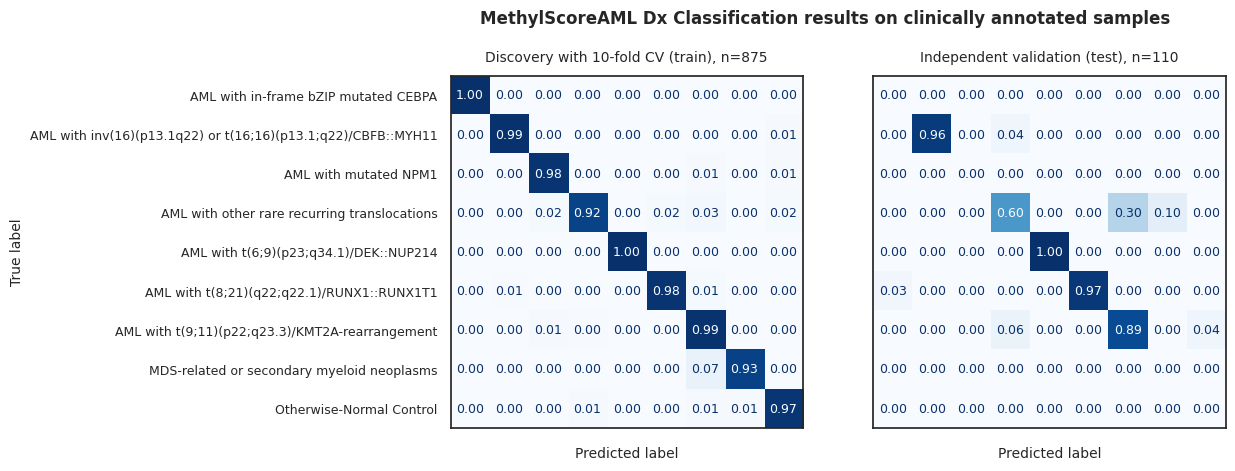

In [19]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from source.data_visualization_functions import plot_confusion_matrix_stacked

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 50, 100, 200], # number of leaves in full tree, which will roughly be the same as max number of features in one-hot encoding
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],  # learning rate
    'n_estimators': [50, 100, 200, 400],  # number of trees (or rounds)
}

# Initialize the LGBM Classifier
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(lgbm, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)  # Predict using the best model

print(f'Overall accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)


## Gaussian Process

Best parameters: {'multi_class': 'one_vs_rest'}
Best cross-validation score: 0.968
Overall accuracy score with best estimator: 0.909


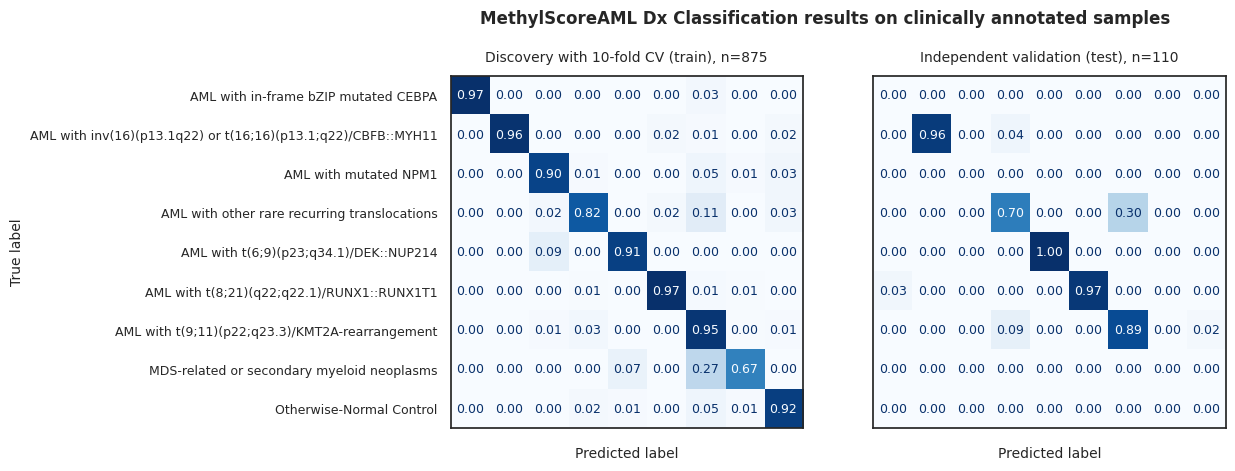

In [20]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Define the parameter grid
param_grid = {
    'multi_class': ['one_vs_rest'],
}

# Initialize the Gaussian Process Classifier
gpc = GaussianProcessClassifier(random_state=42, n_jobs=-1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(gpc, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)  # Predict using the best model

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

print(f'Overall accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)


## Random Forest

Best parameters: {'max_depth': 10, 'n_estimators': 100}
Best cross-validation score: 0.971
Overall accuracy score with best estimator: 0.936


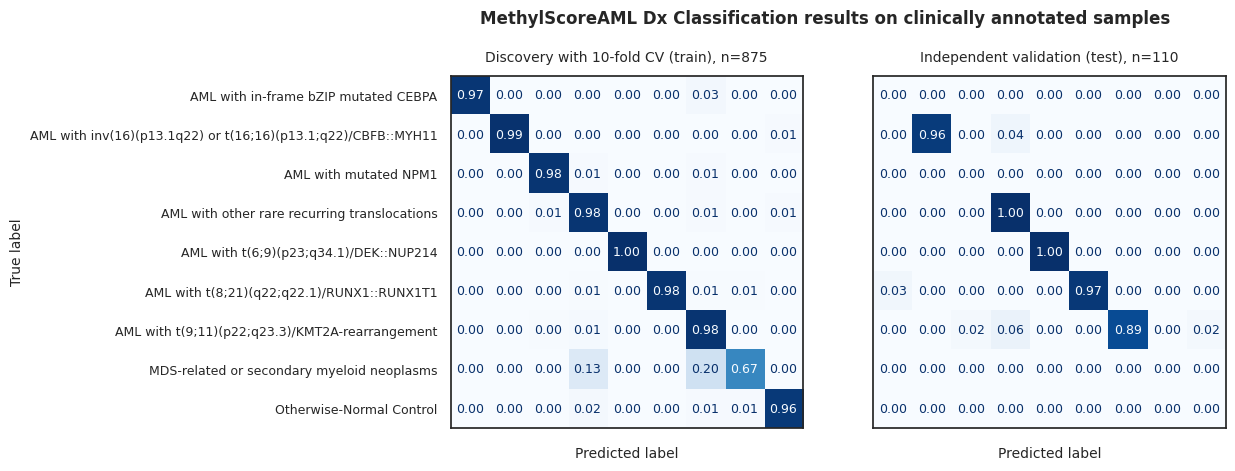

In [21]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # number of trees in the forest
    'max_depth': [None, 5, 10],  # maximum depth of the tree
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)  # Predict using the best model

print(f'Overall accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)


## Logistic Regression

Best parameters: {'C': 10, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.916
Overall accuracy score with best estimator: 0.936


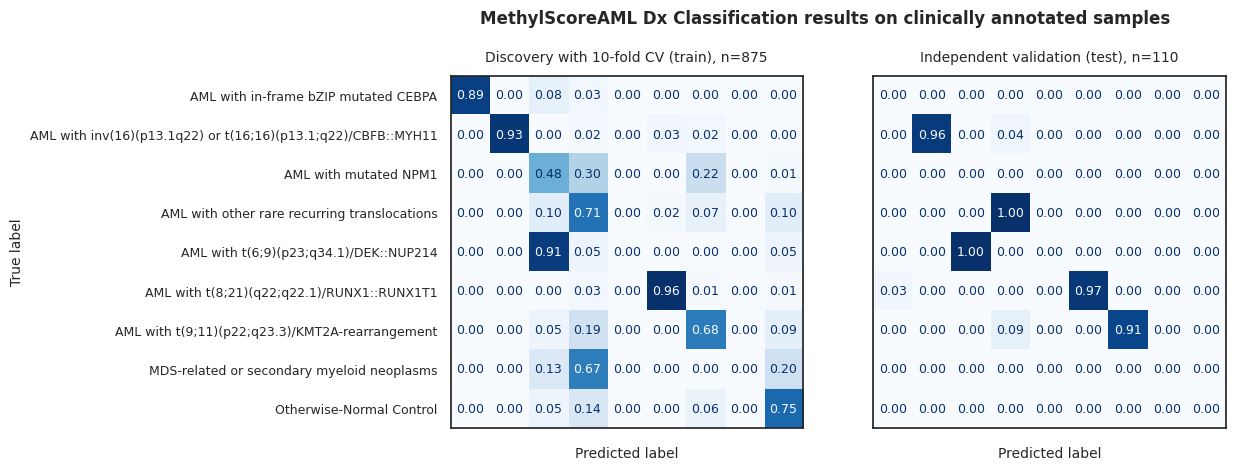

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # regularization strength, smaller values specify stronger regularization
    'penalty': ['l1', 'l2'],  # type of regularization applied
    'solver': ['liblinear'],   # algorithm to use in the optimization problem, 'liblinear' is good for small datasets
    'max_iter': [200, 500, 1000, 2000],  # maximum number of iterations taken for the solvers to converge
}

# Initialize the Logistic Regression Classifier
lr = LogisticRegression(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(lr, param_grid, cv=10, n_jobs=-1, scoring='roc_auc_ovr_weighted')
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using the best estimator
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)  # Predict using the best model

print(f'Overall accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)


## K-Nearest Neighbors

Best parameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best cross-validation score: 0.839
Accuracy score with best estimator: 0.927


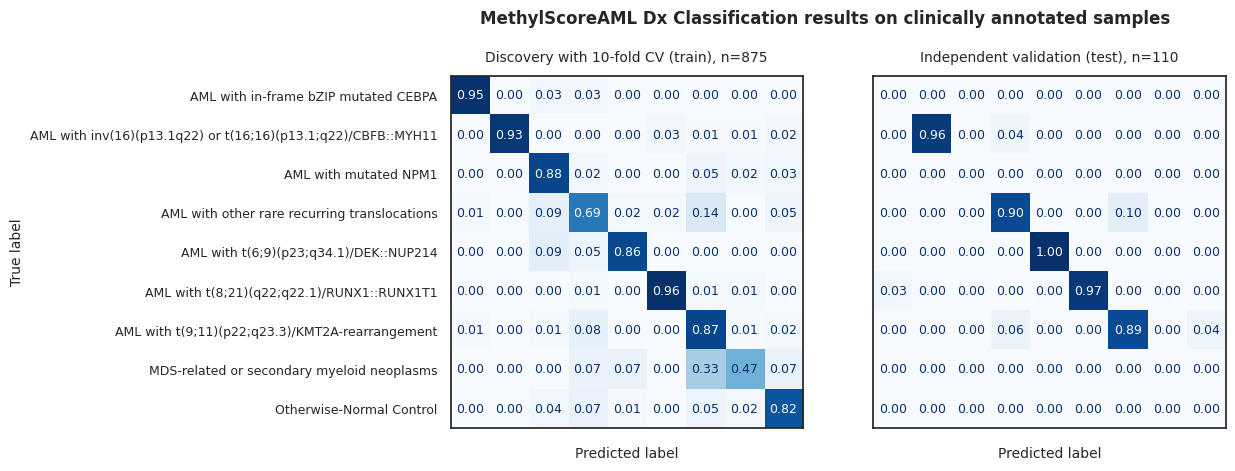

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 18], 
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2]
}

# Initialize KNN classifier
knn = KNeighborsClassifier() 

# Perform grid search  
grid_search = GridSearchCV(knn, param_grid, cv=10, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

# Fit and predict using best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate model on test set
print(f'Accuracy score with best estimator: {accuracy_score(y_test, y_pred):.3f}')

plot_confusion_matrix_stacked(best_model, X_train, y_train, X_test, y_test, tick_fontsize=9, label_fontsize=9)

## Other tests

We have attempted SVM and XGBoost but they either gave us trouble during training or did not perform well.

Soon we will add a PyTorch deep learning benchmark but for now... `LightGBM` rules!

## Watermark

In [ ]:
# Add watermark with all packages used
get_ipython().run_line_magic('load_ext', 'watermark')

In [ ]:
get_ipython().run_line_magic('watermark', '-v -m -p numpy,pandas,sklearn,matplotlib,seaborn,lightgbm -a Francisco_Marchi@Lamba_Lab_UF')

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

numpy     : 1.24.3
pandas    : 2.0.2
sklearn   : 1.2.2
matplotlib: 3.7.1
seaborn   : 0.12.2
lightgbm  : 3.3.5

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

